In this notebook we perform further modelling of the data with a LightGBM model and obtain the submission csv file.

TO DO:
1. HPO of our model(s)
2. Ensembling - Starting with simple averaging of a linear model and gradient boosted trees, as in the programming assignment notebook, and then stacking.
3. Exploration of new features (text descriptions, item categories, seasonal trends etc.)

# Modelling

In [2]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import time
import lightgbm as lgb
import shap
from sklearn.preprocessing import OrdinalEncoder

pd.options.display.max_rows = None

In [3]:
ts = time.time()
#data = pd.read_pickle('/kaggle/input/predict-future-sales-marcus-week-4-part-i/data.pkl')
data = pd.read_pickle('data.pkl')
time.time() - ts

0.5864923000335693

In LightGBM it's possible to specify which features we consider as categorical. Tree decision rule works best when categorical features are presented by consecutive integers starting from zero, so we check if this is true.

In [4]:
def check_cat_feature(feature):
    print("Cat. feature:", feature.name)
    feature_unique = sorted(feature.unique())
    print("First category:", feature_unique[0])
    print("Last category:", feature_unique[-1])
    #print(feature_unique)    
    print("No. unique categories:", len(feature_unique))
    print("No. discontinuities:", sum(np.diff(feature_unique) != 1), "\n")    

data[['item_category_id', 'month', 'shop_id', 'city_code', 'item_id']].apply(check_cat_feature)

Cat. feature: item_category_id
First category: 0
Last category: 83
No. unique categories: 83
No. discontinuities: 1 

Cat. feature: month
First category: 0
Last category: 11
No. unique categories: 12
No. discontinuities: 0 

Cat. feature: shop_id
First category: 2
Last category: 59
No. unique categories: 57
No. discontinuities: 1 

Cat. feature: city_code
First category: 0
Last category: 13
No. unique categories: 14
No. discontinuities: 0 

Cat. feature: item_id
First category: 0
Last category: 22169
No. unique categories: 21158
No. discontinuities: 883 



item_category_id    None
month               None
shop_id             None
city_code           None
item_id             None
dtype: object

**Note:** item_id is especially problematic - perhaps it would be an improvement if we relabeled it.
**New result:** It is not a good idea to set a feature with high cardinality as categorical, and the discontinuities that are present will probably not affect the modelling - we completely skip setting item_id as categorical in the LightGBM model.

We try using OrdinalEncoder() on item_id.

In [5]:
#oe = OrdinalEncoder()
#data['item_id'] = oe.fit_transform(data['item_id'].values.reshape(-1, 1))    

**Note:** LabelEncoder() is only supposed to be applied to target the target variable, so we use OrdinalEncoder() even though LabelEncoder probably would be OK to use here.

In [6]:
#check_cat_feature(data.item_id)

We try using OrdinalEncoder on the categorical features that have dicontinuities.

In [7]:
#oe = OrdinalEncoder()
#data[['item_category_id', 'shop_id']] = oe.fit_transform(data[['item_category_id', 'shop_id']]) 

In [8]:
#data[['item_category_id', 'shop_id']].apply(check_cat_feature)

We try to find potential candidates to set as categorical in the model. We arbitrarily set the limit of unique no. categories to be 100 (item_category_id had 83 different categories). 

In [9]:
ts = time.time()
my_nunique = data.nunique().sort_values()
time.time() - ts

13.02791166305542

In [10]:
my_nunique = my_nunique[my_nunique < 100]
my_nunique = my_nunique[my_nunique.index.\
                        drop(['item_category_id', 'month', 'shop_id', 'city_code', 'item_cnt_month_shop_item'])]

In [11]:
my_nunique

revenue_month_shop_lag_1           3
revenue_month_shop_lag_3           3
no_days_in_month                   3
revenue_month_shop_lag_2           3
category_code                      5
type_code                          9
delta_revenue_lag_1               16
item_cnt_month_shop_item_lag_1    21
item_cnt_month_shop_item_lag_2    21
item_cnt_month_shop_item_lag_3    21
item_cnt_month_mean_lag_1         32
date_block_num                    32
item_cnt_month_mean_lag_2         32
item_cnt_month_mean_lag_3         32
item_shop_last_sale               34
item_shop_first_sale              35
item_last_sale                    35
item_first_sale                   35
subtype_code                      65
dtype: int64

We select some categorical features (the ones that make sense).

In [12]:
my_nunique_select = ['no_days_in_month', 'category_code', 'type_code', 'subtype_code']

In [13]:
test = pd.read_csv('kaggle/input/competitive-data-science-predict-future-sales/test.csv')

In [14]:
X = data.drop('item_cnt_month_shop_item', axis = 1) # We drop the target.

X_train = X[X.date_block_num < 33]
y_train = data[data.date_block_num < 33]['item_cnt_month_shop_item']

X_val = X[X.date_block_num == 33]
y_val = data[data.date_block_num == 33]['item_cnt_month_shop_item']

X_test = X[X.date_block_num == 34]
X_test = X_test.reset_index()
del X_test['index']

In [15]:
print('No. records in training data:', len(X_train))
print('No. records in validation data:', len(X_val))
print('No. records in test data:', len(X_test))

No. records in training data: 9552837
No. records in validation data: 238172
No. records in test data: 214200


In [16]:
del data
del X
gc.collect();

In [17]:
#features_to_keep = pickle.load(open('features_to_keep.save', 'rb'))
#print('Number of features before feature selection:', len(X_train.columns))
#X_train = X_train[features_to_keep]
#X_val = X_val[features_to_keep]
#X_test = X_test[features_to_keep]
#print('Number of features after feature selection:', len(X_train.columns))

In [18]:
#def build_lgb_model(params, X_train, X_val, y_train, y_val):
#    lgb_train = lgb.Dataset(X_train, y_train)
#    lgb_val = lgb.Dataset(X_val, y_val)
#    model = lgb.train(params = params, train_set = lgb_train, valid_sets = (lgb_train, lgb_val), \
#                      verbose_eval = 50)
#    return model

def build_lgb_model(params, X_train, X_val, y_train, y_val, cat_features):
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val)
    model = lgb.train(params = params, train_set = lgb_train, valid_sets = (lgb_train, lgb_val), verbose_eval = 50,
                      categorical_feature = cat_features)    
    return model

In [19]:
#No HPO
#params = {
#    'objective': 'rmse',
#    'metric': 'rmse',    
#    'num_rounds': 1000,
#    'early_stopping_rounds': 30,
#    'seed': 1
#}

#Borrowed HPO
#params = {
#    'objective': 'rmse',
#    'metric': 'rmse',
#    'num_rounds': 2000,
#    'early_stopping_rounds': 30,
#    'seed': 1,
#    'num_leaves': 1023,
#    'min_data_in_leaf':10,
#    'feature_fraction':0.7,
#    'learning_rate': 0.01,  
#}

#Our own HPO
params = {
    'objective': 'rmse',
    'metric': 'rmse',
    'num_rounds': 2000,
    'early_stopping_rounds': 30,
    'seed': 1,
    'num_leaves': 1023,
    'min_data_in_leaf':10,
    'feature_fraction':0.7,
    'learning_rate': 0.01,
    'bagging_fraction': 0.7 # Add bagging_fraction (subsample), following JFP's advice.
}

# Designating the categorical features which should be focused on
cat_features = ['item_category_id', 'month', 'shop_id', 'city_code']

#cat_features = ['item_category_id', 'month', 'shop_id', 'city_code', 'item_id'] # Consider adding item_id.

#cat_features = cat_features + list(my_nunique.index) # Consider adding all categorical features with low \
# cardinality.

cat_features = cat_features + my_nunique_select # We consider adding some features with low cardinality.

In [20]:
ts = time.time()

#model = build_lgb_model(params, X_train, X_val, y_train, y_val)
model = build_lgb_model(params, X_train, X_val, y_train, y_val, cat_features)

time.time() - ts

Found `num_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['category_code', 'city_code', 'item_category_id', 'month', 'no_days_in_month', 'shop_id', 'subtype_code', 'type_code']


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.684737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13840
[LightGBM] [Info] Number of data points in the train set: 9552837, number of used features: 78


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 0.294037
Training until validation scores don't improve for 30 rounds
[50]	training's rmse: 0.974574	valid_1's rmse: 0.98487
[100]	training's rmse: 0.853228	valid_1's rmse: 0.919007
[150]	training's rmse: 0.787981	valid_1's rmse: 0.893718
[200]	training's rmse: 0.751458	valid_1's rmse: 0.882052
[250]	training's rmse: 0.726767	valid_1's rmse: 0.877524
[300]	training's rmse: 0.708394	valid_1's rmse: 0.874712
[350]	training's rmse: 0.693912	valid_1's rmse: 0.872926
[400]	training's rmse: 0.681599	valid_1's rmse: 0.87141
[450]	training's rmse: 0.67161	valid_1's rmse: 0.870159
[500]	training's rmse: 0.663364	valid_1's rmse: 0.869233
[550]	training's rmse: 0.656515	valid_1's rmse: 0.868517
[600]	training's rmse: 0.650289	valid_1's rmse: 0.867832
[650]	training's rmse: 0.644564	valid_1's rmse: 0.867395
[700]	training's rmse: 0.639561	valid_1's rmse: 0.866882
[750]	training's rmse: 0.635081	valid_1's rmse: 0.866479
[800]	training's rmse: 0.630756	val

969.5383920669556

In [21]:
filename = 'lgb_model_#14' 

In [22]:
model.save_model('models/' + filename + '.txt')

In [20]:
#model = lgb.Booster(model_file = 'models/' + filename + '.txt')

We try retraining the model on all of the available data.

In [23]:
#retrain_dataset = lgb.Dataset(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

In [27]:
#params = {
#    'objective': 'rmse',
#    'metric': 'rmse',
#    'num_rounds': 2000,
#    #'early_stopping_rounds': 30,
#    'seed': 1,
#    'num_leaves': 1023,
#    'min_data_in_leaf':10,
#    'feature_fraction':0.7,
#    'learning_rate': 0.01,  
#}

In [28]:
#model_retrain = lgb.train(params, retrain_dataset, init_model = model, verbose_eval = 50)

In [23]:
#model_retrain.save_model('models/lgb_model_#13_retrain.txt')

In [24]:
y_test = model.predict(X_test).clip(0, 20)

my_submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_test
})
my_submission.to_csv('lgb_submission.csv', index=False)
my_submission.head()

,ID,item_cnt_month
0,0,0.435450
1,1,0.269324
2,2,0.973850
3,3,0.457570
4,4,0.727240


<Figure size 432x288 with 0 Axes>

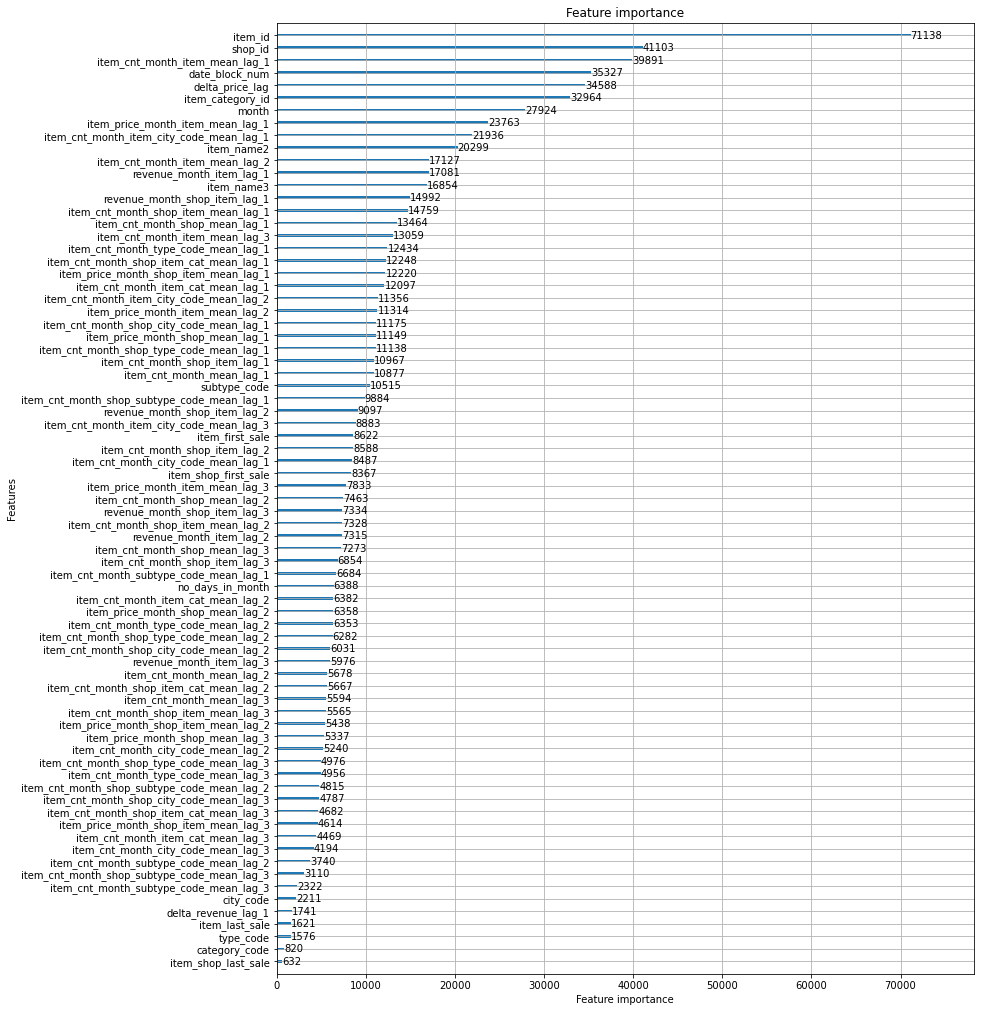

In [25]:
plt.tight_layout()
plot = lgb.plot_importance(model, figsize = (12.5, 17.5))
fig = plot.get_figure()
fig.savefig('plots/' + filename + '.jpg')

**Note:** 
- The features are found to generally have a much lower importance in model #2 compared with #1.
- This implementation of feature importance is perhaps not very useful. Maybe it's better to use SHAP (see the notebook 'Beware of categorical features in LGBM' and Luke M's response).


In [28]:
print('Number of features before feature selection:', len(model.feature_importance()))
features_to_keep_lgb = []
thresh = 0
for feat_imp, feat_name in zip(model.feature_importance(), model.feature_name()):
    if feat_imp > thresh:
        features_to_keep_lgb.append(feat_name)
print('Number of features after feature selection:', len(features_to_keep_lgb))
print('Features excluded:', set(list(X_train.columns)) - set(features_to_keep_lgb))

Number of features before feature selection: 78
Number of features after feature selection: 75
Features excluded: {'revenue_month_shop_lag_3', 'revenue_month_shop_lag_2', 'revenue_month_shop_lag_1'}


In [30]:
pickle.dump(features_to_keep_lgb, open('features_to_keep_lgb.save', 'wb'))

# Evaluation of models

1. Score: 0.92230 (better), train. score: 0.774059, val. score: 0.889531, Coursera public/private score: 10/10 (0.928094) - Default lgb model (only num_round: 1000 and early_stopping_rounds: 30), categorical_feature not used (lgb_model_#1)

2. Score: 0.90437 (better), train. score: 0.816814, val. score: 0.890085, Coursera private score: 10/10 (0.911610) - (lgb_model_#2) - cat_features = ['item_category_id', 'month', 'shop_id', 'city_code'] (lgb_model_#2)

**Note:** This result is quite suprising (top 15% score). Both train. and val. scores are worse than for #1, but the difference between train and val. is smaller (perhaps an important measure). Since we set cat_features manually, and do not let LightGBM decide itself which features to consider as categorical, we probably get some kind of regularization. It is also worth noting that many more features are found to have 0 importance, and many more have a very low importance (<10), which probably also acts as a kind of regularization.

3. **(HPO)** Score: 0.88668 (better), train. score: 0.611059, val. score: 0.865254, Coursera private score: 10/10 (0.895413) - (lgb_model_#3) - HPO used by Luke M,

**Note:** A very good score which gives us a ranking of #598. Also, with HPO more features have a higher importance according to the feature importance plot.

4. **(HPO)** Score: 0.90610 (worse), train. score: 0.573236, val. score: 0.86665 - (lgb_model_#4) - Add item_id to cat_features.

**Note:** We get a very low train. score (even lower than what Luke M gets), but the the val. score isn't improved (huge difference now). This must be an evident example of overfitting and regularization should hopefully remedy the situation.

5. **(HPO)** Score: 0.91165, train. score: 0.598947, val. score: 0.868663 - (lgb_model_#5) - Add item_id to cat_features and use LabelEncoder() on it.

6. **(HPO)** Score: 0.90610 , train. score: 0.573236, val. score: 0.86665 - (lgb_model_#6) - Make sure item_id consists of continuous integers.

**Note:** Perhaps the HPO is not optimal for this choice of cat features.

7. Score: 0.95441 (worse, also worse than lgb_model_#2), train. score: 0.706036, val. score: 0.91014 - (lgb_model_#7) - Same as the previous model but no HPO this time.

8. Score: 0.95441, train. score: 0.706036, val. score: 0.91014 - (lgb_model_#8) - No HPO and no relabelling of item_id.

**Note:** The relabelling doesn't change anything.

**Response from Luke M:** According to the documentation of LightGBM (https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html), it is not a good idea to set a feature with high cardinality as categorical, it's better to treat it as numerical.

9. Score: -, train. score: 0.816814, val. score: 0.890085 - (lgb_model_#9) - We do not set item_id as categorical, we relabel categorial features that have discontinuities (item_category_id and shop_id).

**Note:** We get exactly the same train and val score as before so not worth bothering.

10. Score: 0.92060 (worse), train. score: 0.767382, val. score: 0.881765- (lgb_model_#10) - Add features with low caridnality (<100) as categorical features (no HPO).

**Note:** This is not a very smart way of adding categorical features (it makes no sense to have date_block_num as a categorical feature).

11. Score: 0.89822 (worse, but better than lgb_model_#2), train. score: 0.77139, val. score: 0.878494 - (lgb_model_#11) - Add certain features with low cardinality (<100) as categorical features (no HPO).

**Note:** It is probably a good idea to keep these categorical features, and try HPO on them.

12. **(HPO)** Score: 0.88808 (worse), train. score: 0.628101, val. score: 0.866039 - (lgb_model_#12) - Add  certain features with low caridnality (<100) as categorical features (with HPO).
	 
**Note:** This submission gets a worse score than our best submission so far, but the current selection of cat_features is probably adapted to the current HPO, so it's probably a good idea to redo the HPO for this new selection.

13. **(HPO)** Score: 0.92048 (worse) - We select lgb_model_#3 and retrain it on all data, setting train and val data as train data (lgb_model_#13_retrain).

**Note:** This did not improve the score, and questionable if it really works, especially as we're not really using CV when we train the model.

14. **(HPO)** Score: (worse), train. score: , val. score:  - (lgb_model_#14) - Add  certain features with low caridnality (<100) as categorical features (with HPO) and set bagging_fraction = 0.7 (subsample).

**Note:** Adding baggin_fraction = 0.7 did not change anything.